In [1]:
from eolearn.stac import STACInputTask
from eolearn.core import SaveTask, OverwritePermission, LinearWorkflow, EOExecutor
from sentinelhub import BBox, CRS
from datetime import date
import logging
import os

In [2]:
OUTPUT_DIR = "l8-patches"
CACHE_DIR = "l8-cache"

/home/munshkr/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
add_l8_data = STACInputTask(
    catalog_url="https://earth-search.aws.element84.com/v0",
    collection_name="landsat-8-l1-c1",
    assets={"B4", "B3", "B2"},
)

save = SaveTask(
    OUTPUT_DIR,
    overwrite_permission=OverwritePermission.OVERWRITE_PATCH,
)

workflow = LinearWorkflow(
    add_l8_data,
    save
)

In [5]:
bboxes = [
    BBox([-64.3097860799999808,-31.5249839339999767, -64.0573813509999468,-31.3085281599999803], CRS('4326'))
]
time_interval = (date(2020, 10, 1), date(2020, 10, 31))

## Debug

In [6]:
# logging.basicConfig(level=logging.DEBUG)

In [7]:
# add_l8_data.execute(bbox=bboxes[0], time_interval=time_interval)

## Workflow

In [8]:
execution_args = []
for i, bbox in enumerate(bboxes):
    execution_args.append(
        {
            add_l8_data: {"bbox": bbox, "time_interval": time_interval},
            save: {"eopatch_folder": str(i)},
        }
    )

In [9]:
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5, multiprocess=True)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_filename()}"
    )

  0%|          | 0/1 [00:00<?, ?it/s]

## Visualize patches

In [10]:
from eolearn.core import EOPatch
import matplotlib.pyplot as plt

/home/munshkr/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
patch = EOPatch.load(os.path.join(OUTPUT_DIR, '0'))
patch

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(2, 809, 809, 1), dtype=uint16)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    size_x: 809
    size_y: 809
    stac_items: '[[[[{"type": "Feature", "stac_version": "1.0.0-beta.2", "id": "LC08_L1TP_229082_20201028_20201106_01_T1", "properties": {"gsd": 30, "platform": "LANDSAT_8", "instruments": ["OLI", "TIRS"], "eo:cloud_cover": 93.76, "proj:epsg": 32720, "view:sun_azimuth": 60.64346583, "view:sun_elevation": 58.57861369, "view:off_nadir": 0.001, "landsat:scene_id": "LC82290822020302LGN00", "landsat:processing_level": "L1TP", "landsat:collection_number": "01", "landsat:collection_category": "T1", "landsat:cloud_cover_land": 93.76, "landsat:wrs_path": "229", "landsat:wrs_row": "82", "datetime": "2020-10-28T14:08:52.880178Z", "created": "2020-11-09T23:11:08.389Z", "updated": "2020-11-09T23:11:08.389Z"}, "geomet

In [14]:
img = patch.data['BANDS'][0, ..., 0]

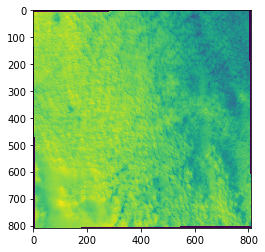

In [16]:
plt.imshow(img)